In [1]:
import dill
import jupyter_contrib_nbextensions

In [2]:
#import all utilities imports
import matplotlib as mp, pandas as pd, numpy as np, geopandas as gpd
import functools
import math
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pysal as ps
import random
import pylab
import matplotlib.colors as cols
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point, LineString, MultiLineString
from numpy.random import randn
from scipy import sparse
from scipy.sparse import linalg
import matplotlib.patches as mpatches
import sys
from time import sleep
pd.set_option('precision', 10)
from mpl_toolkits.mplot3d.art3d import Line3DCollection

#import all street network fuctions imports
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np, geopandas as gpd
import functools
import community
import math
from math import sqrt
import matplotlib.pyplot as plt
import ast

from scipy import sparse
from scipy.sparse import linalg
import pysal as ps

from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping, MultiLineString
from shapely.ops import cascaded_union, linemerge, nearest_points
pd.set_option('precision', 10)

#import computational notebook functions
import networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import community
import matplotlib.pyplot as plt
from importlib import reload
import geopandas as gpd
import functools
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [9]:
import street_network_functions as snf
import utilities as uf
import routing_functions as rf

In [4]:
#initialise path, names, etc.

city_name = 'Valencia'
saving_path ='dataComp/'+'Valencia' +'/'
epsg = 4326
crs = {'init': 'epsg:4326', 'no_defs': True}

## 1. create dual graph

In [5]:
dill.load_session('CreatePrimalDiGraph.db')

In [6]:
edgesP.head()

,u,v,key,streetID,geometry,length,highway,oneway,pedestrian,grade,grade_abs,name,hasBikeP,slopeCost,weightP1,weightP2,weightP3,weightBike,edgeID
edgeID,,,,,,,,,,,,,,,,,,,
1,2,5442,0,6,"LINESTRING (-0.35455 39.47602, -0.35442 39.47629)",32.128,cycleway,0,0,0.016,0.016,NaN,1,10.884,7.171,10.884,10.884,0,1
2,2,6,0,7,"LINESTRING (-0.35455 39.47602, -0.35462 39.47588)",16.423,cycleway,0,0,-0.013,0.013,NaN,1,3.666,3.666,3.666,3.666,0,2
3,2,6551,0,8,"LINESTRING (-0.35455 39.47602, -0.35497 39.476...",65.709,primary,1,0,0.025,0.025,Avinguda de Blasco Ibáñez,0,26.884,14.667,26.884,29.513,1,3
4,3,3542,0,9,"LINESTRING (-0.39384 39.45899, -0.39386 39.459...",47.111,pedestrian,0,1,0.013,0.013,Carrer d'En Galceràn,0,15.017,10.516,15.017,16.902,1,4
5,3,4568,0,10,"LINESTRING (-0.39384 39.45899, -0.39353 39.458...",42.766,pedestrian,0,1,0.008,0.008,NaN,0,12.080,9.546,12.080,13.791,1,5


In [7]:
nodesP.head()

,nodeID,x,y,geometry,elevation
2,2,-0.355,39.476,POINT (-0.35455 39.47602),9.304
3,3,-0.394,39.459,POINT (-0.39384 39.45899),18.489
4,4,-0.343,39.481,POINT (-0.34340 39.48101),6.834
6,6,-0.355,39.476,POINT (-0.35462 39.47588),9.094
8,8,-0.373,39.463,POINT (-0.37266 39.46254),12.923


In [13]:
def dual_gdf(nodes_gdf, edges_gdf, crs):
    # computing centroids                                       
    centroids_gdf = edges_gdf.copy()
    centroids_gdf['centroid'] = centroids_gdf['geometry'].centroid
    centroids_gdf['intersecting'] = None

    index_u = centroids_gdf.columns.get_loc("u")+1
    index_v = centroids_gdf.columns.get_loc("v")+1
    index_edgeID = centroids_gdf.columns.get_loc("edgeID")+1

    print('complete 1/6: computing centroids')

    # find_intersecting segments and storing them in the centroids gdf
    processed = []
    for c in centroids_gdf.itertuples():
        intersections = []
        from_node = c[index_u]
        to_node = c[index_v]
        
        #
        possible_intersections = centroids_gdf.loc[(centroids_gdf['u'] == to_node) & (centroids_gdf['v'] != from_node)]

        for p in possible_intersections.itertuples():
            if ((c[0]==p[0]) | ((c[0], p[0]) in processed) | ((p[0], c[0]) in processed)): continue
        
            else:
                intersections.append(p[index_edgeID])  # appending edgeID
                processed.append((p[0],c[0]))
    
        centroids_gdf.set_value(c[0],'intersecting', intersections)
    
    print('complete 2/6: adding intersecting segments')

     # creating vertexes representing street segments (centroids)
    centroids_data = centroids_gdf[['edgeID','streetID', 'intersecting', 'length','grade', 'grade_abs', 'name', 'slopeCost', 'hasBikeP', 'weightP1', 'weightP2', 'weightP3']]
    geometry = centroids_gdf['centroid']
    nodes_dual = gpd.GeoDataFrame(centroids_data, crs=crs, geometry=geometry)
    nodes_dual['x'] = [x.coords.xy[0][0] for x in centroids_gdf['centroid']]
    nodes_dual['y'] = [y.coords.xy[1][0] for y in centroids_gdf['centroid']]

    print('complete 3/6: create centroids as nodes')

    # creating fictious links between centroids
    edges_dual = pd.DataFrame(columns=['u','v', 'geometry'])

    #index_length = nodes_dual.columns.get_loc("length")+1
    index_edgeID_nd = nodes_dual.columns.get_loc("edgeID")+1
    index_intersecting = nodes_dual.columns.get_loc("intersecting")+1
    index_geo = nodes_dual.columns.get_loc("geometry")+1

    print('complete 4/6: create links as edges ')

    # creating vertexes representing street segments (centroids)
    centroids_data = centroids_gdf[['edgeID','streetID', 'intersecting', 'length','grade', 'grade_abs', 'name', 'slopeCost', 'hasBikeP', 'weightP1', 'weightP2', 'weightP3']]
    geometry = centroids_gdf['centroid']
    nodes_dual = gpd.GeoDataFrame(centroids_data, crs=crs, geometry=geometry)
    nodes_dual['x'] = [x.coords.xy[0][0] for x in centroids_gdf['centroid']]
    nodes_dual['y'] = [y.coords.xy[1][0] for y in centroids_gdf['centroid']]

    # creating fictious links between centroids
    edges_dual = pd.DataFrame(columns=['u','v', 'geometry'])

    #part 5 of 6
    index_edgeID_nd = nodes_dual.columns.get_loc("edgeID")+1
    index_intersecting = nodes_dual.columns.get_loc("intersecting")+1
    index_geo = nodes_dual.columns.get_loc("geometry")+1
    # connecting nodes which represent street segments thare a linked in the actual street network                                        
    for row in nodes_dual.itertuples():
        
        edgeID = row[index_edgeID_nd] #streetID of the relative segment
        #length = row[index_length]
                                                    
        # intersecting segments:  # i is the streetID                                      
        for i in list(row[index_intersecting]):     
                  
            # adding a row with u-v, key fixed as 0, Linestring geometry 
            # from the first centroid to the centroid intersecting segment 
            ls = LineString([row[index_geo], nodes_dual.loc[i]['geometry']])
            edges_dual.loc[-1] = [edgeID, i, ls] 
            edges_dual.index = edges_dual.index + 1
            
    edges_dual = edges_dual.sort_index(axis=0)
    geometry = edges_dual['geometry']
    edges_dual = gpd.GeoDataFrame(edges_dual[['u','v']], crs=crs, geometry=geometry)

    print('complete 5/6: connect nodes representing street segments')

    #part 6 of 6 adding angles
    ix_lineA = edges_dual.columns.get_loc("u")+1
    ix_lineB = edges_dual.columns.get_loc("v")+1

    for row in edges_dual.itertuples():

        # retrieveing original lines from/to
        geo_lineA = edges_gdf[edges_gdf.index == row[ix_lineA]].geometry.iloc[0]
        geo_lineB = edges_gdf[edges_gdf.index == row[ix_lineB]].geometry.iloc[0]

        # computing angles in degrees and radians
        deflection = uf.ang_geoline(geo_lineA, geo_lineB, degree = True, deflection = True)
        deflection_rad = uf.ang_geoline(geo_lineA, geo_lineB, degree = False, deflection = True)

        # setting values                                    
        edges_dual.set_value(row[0],'deg', deflection)
        edges_dual.set_value(row[0],'rad', deflection_rad)
    print('complete 6/6: finish adding angles')
    return nodes_dual, edges_dual

In [14]:
# create dual graph with snf function (10min)
nodesDual, edgesDual = dual_gdf(nodesP, edgesP, crs)

complete 1/6: computing centroids
complete 2/6: adding intersecting segments
complete 3/6: create centroids as nodes
complete 4/6: create links as edges 
complete 5/6: connect nodes representing street segments
complete 6/6: finish adding angles


In [15]:
nodesDual.head()

,edgeID,streetID,intersecting,length,grade,grade_abs,name,slopeCost,hasBikeP,weightP1,weightP2,weightP3,geometry,x,y
edgeID,,,,,,,,,,,,,,,
1,1,6,"[9903, 9905]",32.128,0.016,0.016,NaN,10.884,1,7.171,10.884,10.884,POINT (-0.35449 39.47615),-0.354,39.476
2,2,7,"[10, 11]",16.423,-0.013,0.013,NaN,3.666,1,3.666,3.666,3.666,POINT (-0.35459 39.47595),-0.355,39.476
3,3,8,[11878],65.709,0.025,0.025,Avinguda de Blasco Ibáñez,26.884,0,14.667,26.884,29.513,POINT (-0.35490 39.47613),-0.355,39.476
4,4,9,"[6412, 6413]",47.111,0.013,0.013,Carrer d'En Galceràn,15.017,0,10.516,15.017,16.902,POINT (-0.39401 39.45915),-0.394,39.459
5,5,10,[8276],42.766,0.008,0.008,NaN,12.080,0,9.546,12.080,13.791,POINT (-0.39361 39.45891),-0.394,39.459


In [16]:
edgesDual

,u,v,geometry,deg,rad
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747
...,...,...,...,...,...
50716,3,11878,"LINESTRING (-0.35490 39.47613, -0.35530 39.47638)",51.610,0.901
50717,2,11,"LINESTRING (-0.35459 39.47595, -0.35457 39.47586)",100.320,1.751
50718,2,10,"LINESTRING (-0.35459 39.47595, -0.35469 39.47574)",0.009,0.000
50719,1,9905,"LINESTRING (-0.35449 39.47615, -0.35441 39.47631)",0.008,0.000


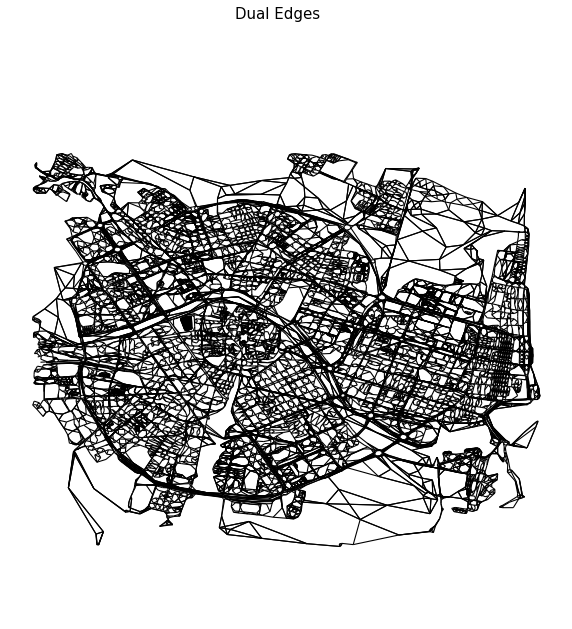

In [17]:
uf.plot_lines(edgesDual, bb = False, f = 10, title = 'Dual Edges')

## 2. add missing columns

In [18]:
nodesD = nodesDual.copy()
edgesD = edgesDual.copy()

In [19]:
edgesD['key']=0

In [20]:
# add parameters
rf.mapCol_Dual(nodesD,edgesD, 'slopeCost', 'slopeCost')
rf.mapCol_Dual(nodesD,edgesD, 'hasBikeP', 'hasBikeP')
rf.mapCol_Dual(nodesD,edgesD, 'length', 'length')
edgesD.head()

,u,v,geometry,deg,rad,key,slopeCost,hasBikeP,length
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000,0,14.777,0.000,41.446
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722,0,13.265,0.000,44.510
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000,0,8.803,0.000,39.436
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403,0,18.941,0.000,84.854
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747,0,22.510,1.000,100.845


In [21]:
# add primal weights
rf.mapCol_Dual(nodesD,edgesD, 'weightP1', 'weightP1')
rf.mapCol_Dual(nodesD,edgesD, 'weightP2', 'weightP2')
rf.mapCol_Dual(nodesD,edgesD, 'weightP3', 'weightP3')
edgesD.head()

,u,v,geometry,deg,rad,key,slopeCost,hasBikeP,length,weightP1,weightP2,weightP3
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000,0,14.777,0.000,41.446,9.251,14.777,16.435
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722,0,13.265,0.000,44.510,9.935,13.265,15.045
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000,0,8.803,0.000,39.436,8.803,8.803,10.380
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403,0,18.941,0.000,84.854,18.941,18.941,22.335
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747,0,22.510,1.000,100.845,22.510,22.510,22.510


## 3. calculate parameter & weights

In [22]:
#create a angular confusion field 
edgesD['angConf'] = 0
edgesD['angConf'] = edgesD['angConf'].astype('float')

In [23]:
edgesD = rf.angConf(edgesD)

In [24]:
#weight 1: only angular confusion
edgesD['weightA1'] = edgesD['angConf']
edgesD.head()

,u,v,geometry,deg,rad,key,slopeCost,hasBikeP,length,weightP1,weightP2,weightP3,angConf,weightA1
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000,0,14.777,0.000,41.446,9.251,14.777,16.435,0.000,0.000
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722,0,13.265,0.000,44.510,9.935,13.265,15.045,5.751,5.751
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000,0,8.803,0.000,39.436,8.803,8.803,10.380,0.000,0.000
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403,0,18.941,0.000,84.854,18.941,18.941,22.335,4.163,4.163
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747,0,22.510,1.000,100.845,22.510,22.510,22.510,5.876,5.876


In [25]:
#weight 2: angular confusion + length
edgesD['weightA2'] = edgesD['angConf']+edgesD['weightP1']
edgesD.head()

,u,v,geometry,deg,rad,key,slopeCost,hasBikeP,length,weightP1,weightP2,weightP3,angConf,weightA1,weightA2
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000,0,14.777,0.000,41.446,9.251,14.777,16.435,0.000,0.000,9.251
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722,0,13.265,0.000,44.510,9.935,13.265,15.045,5.751,5.751,15.686
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000,0,8.803,0.000,39.436,8.803,8.803,10.380,0.000,0.000,8.803
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403,0,18.941,0.000,84.854,18.941,18.941,22.335,4.163,4.163,23.104
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747,0,22.510,1.000,100.845,22.510,22.510,22.510,5.876,5.876,28.386


In [26]:
#weight 3: angular and slope
edgesD['weightA3'] = edgesD['angConf']+edgesD['slopeCost']
edgesD.head()

,u,v,geometry,deg,rad,key,slopeCost,hasBikeP,length,weightP1,weightP2,weightP3,angConf,weightA1,weightA2,weightA3
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000,0,14.777,0.000,41.446,9.251,14.777,16.435,0.000,0.000,9.251,14.777
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722,0,13.265,0.000,44.510,9.935,13.265,15.045,5.751,5.751,15.686,19.016
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000,0,8.803,0.000,39.436,8.803,8.803,10.380,0.000,0.000,8.803,8.803
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403,0,18.941,0.000,84.854,18.941,18.941,22.335,4.163,4.163,23.104,23.104
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747,0,22.510,1.000,100.845,22.510,22.510,22.510,5.876,5.876,28.386,28.386


In [27]:
#weight A4: calculate if there's bike path 
# if there is no bikepath, adding 4s to every 100m
#weight A4 = A3+cost (when no bikepath)
edgesD['weightA4'] = edgesD['angConf']+edgesD['weightP3']
edgesD.head()

,u,v,geometry,deg,rad,key,slopeCost,hasBikeP,length,weightP1,weightP2,weightP3,angConf,weightA1,weightA2,weightA3,weightA4
0,26061,11705,"LINESTRING (-0.34306 39.48010, -0.34352 39.48023)",0.003,0.000,0,14.777,0.000,41.446,9.251,14.777,16.435,0.000,0.000,9.251,14.777,16.435
1,26061,11704,"LINESTRING (-0.34306 39.48010, -0.34320 39.48035)",98.637,1.722,0,13.265,0.000,44.510,9.935,13.265,15.045,5.751,5.751,15.686,19.016,20.796
2,26060,11702,"LINESTRING (-0.34283 39.48006, -0.34274 39.48024)",0.026,0.000,0,8.803,0.000,39.436,8.803,8.803,10.380,0.000,0.000,8.803,8.803,10.380
3,26060,11701,"LINESTRING (-0.34283 39.48006, -0.34236 39.47994)",80.362,1.403,0,18.941,0.000,84.854,18.941,18.941,22.335,4.163,4.163,23.104,23.104,26.498
4,26059,2660,"LINESTRING (-0.34300 39.47975, -0.34264 39.47933)",100.085,1.747,0,22.510,1.000,100.845,22.510,22.510,22.510,5.876,5.876,28.386,28.386,28.386


## 4. create dual graph

In [28]:
DualDiG = rf.get_dual_Digraph(nodesD,edgesD)

In [29]:
DualDiG.nodes[2]

{'edgeID': 2,
 'streetID': 7,
 'length': 16.423,
 'grade': -0.0128,
 'grade_abs': 0.0128,
 'slopeCost': 3.6658482142857136,
 'hasBikeP': 1,
 'weightP1': 3.6658482142857136,
 'weightP2': 3.6658482142857136,
 'weightP3': 3.6658482142857136,
 'geometry': <shapely.geometry.point.Point at 0x159bc6fcac8>,
 'x': -0.3545884,
 'y': 39.47594895}

# END

In [30]:
DualDiG.graph['crs'] = crs

In [31]:
DualDiG.graph['name'] = city_name

In [32]:
nodesD_gdf=nodesD.copy()

In [33]:
nodesD_gdf = nodesD_gdf.drop(columns=['intersecting'])

In [34]:
# gdf download
nodesD_gdf .crs = crs
nodesD_gdf .to_file(saving_path+'nodesD.shp', driver = 'ESRI Shapefile')
edgesD.crs = crs
edgesD.to_file(saving_path+'edgesD.shp', driver = 'ESRI Shapefile')

In [35]:
dill.dump_session('CreateDualDiGraph.db')

In [2]:
dill.load_session('CreateDualDiGraph.db')